In [1]:
import sys, os
sys.path.append(os.path.join(os.path.dirname(os.path.realpath('__file__')), '..'))

from src.lobe.fermionic import fermionic_plus_hc_block_encoding, fermionic_product_block_encoding
from src.lobe.bosonic import bosonic_mode_block_encoding
from src.lobe.system import System
from openparticle import ParticleOperator, generate_matrix
from src.lobe._utils import get_basis_of_full_system
import cirq
from cirq.contrib.svg import SVGCircuit
import numpy as np

In [2]:
MAX_MODES = 5
MAX_ACTIVE_MODES = 3
MIN_ACTIVE_MODES = 2

In [7]:
number_of_active_modes = np.random.random_integers(
    MIN_ACTIVE_MODES, MAX_ACTIVE_MODES
)
active_modes = np.random.choice(
    range(MAX_MODES + 1), size=number_of_active_modes, replace=False
)

operator_types_reversed = np.random.choice(
    [2, 1, 0], size=number_of_active_modes, replace=True
)

while np.allclose(operator_types_reversed, [2] * number_of_active_modes):
    operator_types_reversed = np.random.choice(
        [2, 1, 0], size=number_of_active_modes, replace=True
    )
operator_types_reversed = operator_types_reversed[:number_of_active_modes]
operator_types_reversed = list(operator_types_reversed)

operator_string = ""
for mode, operator_type in zip(active_modes, operator_types_reversed):
    if operator_type == 0:
        operator_string += f" b{mode}"
    if operator_type == 1:
        operator_string += f" b{mode}^"
    if operator_type == 2:
        operator_string += f" b{mode}^ b{mode}"

operator = ParticleOperator(operator_string)

operator

1.0 * b1^ b5

<src.lobe.system.System object at 0x1059336a0> q(1) [1 5] [1, 0] [cirq.LineQubit(2), cirq.LineQubit(3), cirq.LineQubit(4), cirq.LineQubit(5), cirq.LineQubit(6), cirq.LineQubit(7), cirq.LineQubit(8), cirq.LineQubit(9), cirq.LineQubit(10), cirq.LineQubit(11), cirq.LineQubit(12), cirq.LineQubit(13), cirq.LineQubit(14), cirq.LineQubit(15), cirq.LineQubit(16), cirq.LineQubit(17), cirq.LineQubit(18), cirq.LineQubit(19), cirq.LineQubit(20), cirq.LineQubit(21), cirq.LineQubit(22), cirq.LineQubit(23), cirq.LineQubit(24), cirq.LineQubit(25), cirq.LineQubit(26), cirq.LineQubit(27), cirq.LineQubit(28), cirq.LineQubit(29), cirq.LineQubit(30), cirq.LineQubit(31), cirq.LineQubit(32), cirq.LineQubit(33), cirq.LineQubit(34), cirq.LineQubit(35), cirq.LineQubit(36), cirq.LineQubit(37), cirq.LineQubit(38), cirq.LineQubit(39), cirq.LineQubit(40), cirq.LineQubit(41), cirq.LineQubit(42), cirq.LineQubit(43), cirq.LineQubit(44), cirq.LineQubit(45), cirq.LineQubit(46), cirq.LineQubit(47), cirq.LineQubit(48), ci

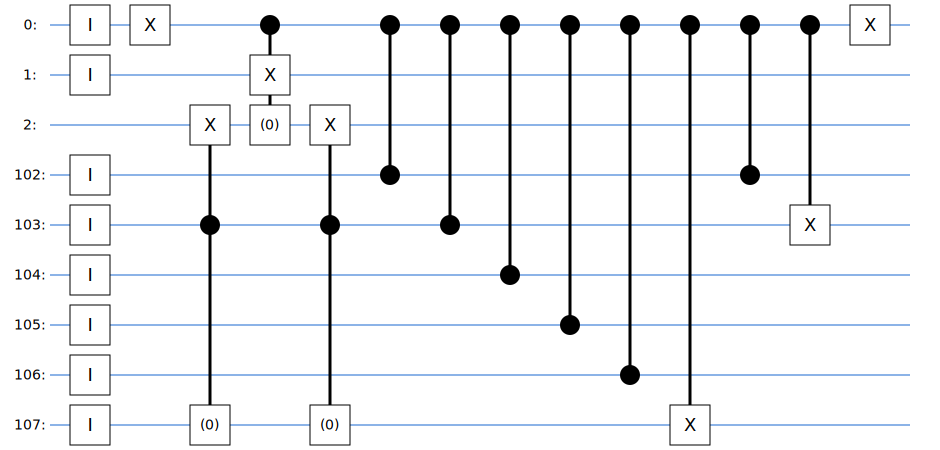

In [8]:
number_of_modes = max([term.max_mode for term in operator.to_list()]) + 1

number_of_clean_ancillae = 100

# Declare Qubits
circuit = cirq.Circuit()
control = cirq.LineQubit(0)
block_encoding_ancilla = cirq.LineQubit(1)

clean_ancillae = [cirq.LineQubit(i + 2) for i in range(number_of_clean_ancillae)]
system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=1,
    number_of_used_qubits=2 + number_of_clean_ancillae,
    has_fermions=True,
)
circuit.append(
    cirq.I.on_each(
        control,
        block_encoding_ancilla,
        *system.fermionic_register,
    )
)

print(system, block_encoding_ancilla, active_modes, operator_types_reversed, clean_ancillae, control)
# Flip control qubit so that we can focus on the 0-subspace of the control
circuit.append(cirq.X.on(control))
# Generate full Block-Encoding circuit
gates, metrics = fermionic_product_block_encoding(
    system,
    block_encoding_ancilla,
    active_modes[::-1],
    operator_types_reversed[::-1],
    clean_ancillae=clean_ancillae,
    ctrls=([control], [1]),
)
circuit += gates
# Flip control qubit so that we can focus on the 0-subspace of the control
circuit.append(cirq.X.on(control))
print(operator)
SVGCircuit(circuit)

1.0 * a1^ a1



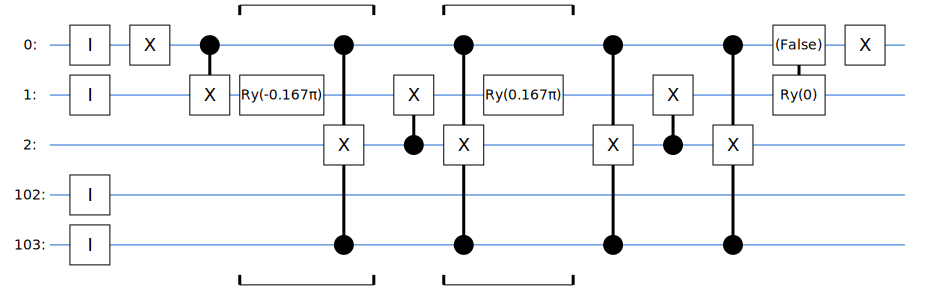

In [36]:
number_of_modes = 2
active_mode = 1
maximum_occupation_number = 1
R = 1
S = 1

active_mode = active_mode % number_of_modes
operator = ParticleOperator(f"a{active_mode}^") ** R
operator *= ParticleOperator(f"a{active_mode}") ** S

number_of_modes = max([term.max_mode for term in operator.to_list()]) + 1

number_of_clean_ancillae = 100

# Declare Qubits
circuit = cirq.Circuit()
control = cirq.LineQubit(0)
block_encoding_ancilla = cirq.LineQubit(1)

clean_ancillae = [cirq.LineQubit(i + 2) for i in range(number_of_clean_ancillae)]
system = System(
    number_of_modes=number_of_modes,
    maximum_occupation_number=maximum_occupation_number,
    number_of_used_qubits=2 + number_of_clean_ancillae,
    has_fermions=False,
    has_bosons=True,
)
circuit.append(
    cirq.I.on_each(
        control,
        block_encoding_ancilla,
        *system.bosonic_system,
    )
)


# Flip control qubit so that we can focus on the 0-subspace of the control
circuit.append(cirq.X.on(control))
# Generate full Block-Encoding circuit
gates, metrics = bosonic_mode_block_encoding(
    system,
    block_encoding_ancilla,
    active_mode,
    (R, S),
    clean_ancillae=clean_ancillae,
    ctrls=([control], [1]),
)
circuit += gates
# Flip control qubit so that we can focus on the 0-subspace of the control
circuit.append(cirq.X.on(control))

print(operator)
SVGCircuit(circuit)

In [39]:
full_fock_basis = get_basis_of_full_system(
    number_of_modes,
    maximum_occupation_number=maximum_occupation_number,
    has_fermions=operator.has_fermions,
    has_antifermions=operator.has_antifermions,
    has_bosons=operator.has_bosons,
)
matrix = generate_matrix(operator, full_fock_basis)

upper_left_block = (
        (np.sqrt(maximum_occupation_number + 1)) ** ((R + S))
    ) * circuit.unitary(dtype=complex)[
    : 1 << system.number_of_system_qubits, : 1 << system.number_of_system_qubits
]

assert np.allclose(upper_left_block, matrix)